# <font color='green'> <center> **Air Passengers Domestic Demand** </center> </font> 

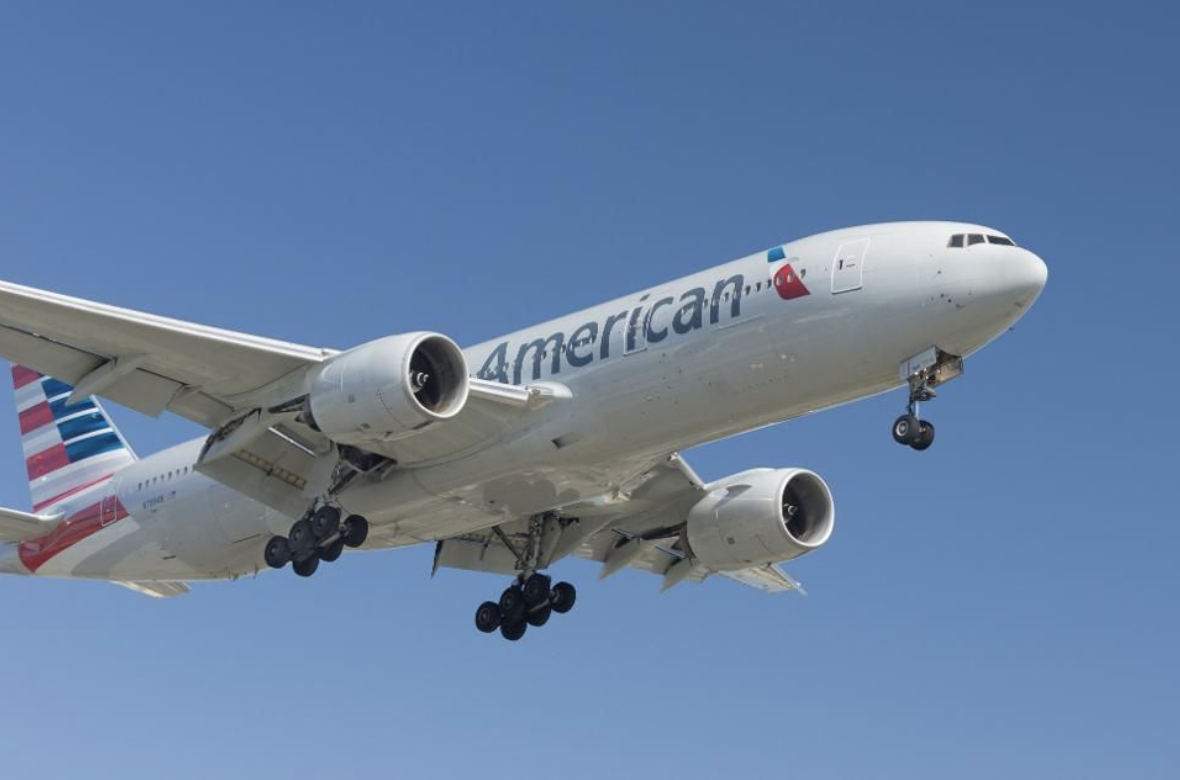

In [49]:
from IPython.display import Image
Image(filename='US_Airline.png', width=700)

# <font color='blue'> Data Loading and Data Procession  


https://bashtage.github.io/linearmodels/doc/panel/models.html#linearmodels.panel.model.PanelOLS  
https://bashtage.github.io/linearmodels/doc/panel/covariance.html  
https://bashtage.github.io/linearmodels/doc/panel/reference.html#heteroskedasticity-robust-covariance-estimator  
https://bashtage.github.io/linearmodels/doc/system/reference.html  
https://bashtage.github.io/linearmodels/doc/system/index.html  
If ids<150 then dumu car


    
Another usefull references: [Histograms and Density](https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0), [Kaggle](https://www.kaggle.com/gpanigrahi/airline-fare-prediction)

In [2]:
# Importning libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.animation as animation

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence

import glob
from glob import iglob
import pandas as pd

%matplotlib inline

## <font color='green'> **Air Fare Information for Consumers**  
    
**`Informations`**: The data about [Air Fare Information for Consumers](https://www.transportation.gov/policy/aviation-policy/air-fare-information-consumers) is downloaded from the [Department of Transportation](https://www.transportation.gov) website.
    
> "Each month the **Department of Transportation** releases an Air Travel Consumer Report that includes [information](https://www.transportation.gov/policy/aviation-policy/air-fare-information-consumers) about various service quality elements, including flight delays, mishandled baggage, and oversales, and a variety of other types of consumer complaints.  
In response to an increasing number of inquiries from consumers about domestic airline prices the Department decided to release a quarterly fare report. The first such report, for the third quarter of 1996, was released in June 1997.  
The initial report provided information about average prices being paid by consumers in the 1,000 largest domestic city-pair markets within the 48 contiguous states. These markets account for about 75 percent of all 48-state passengers and 70 percent of total domestic passengers."  

**`Database`**:  Among the data relating to the [Domestic Airline Consumer Airfare Report](https://www.transportation.gov/policy/aviation-policy/domestic-airline-consumer-airfare-report) available on the website, we retain only [Table 6](https://data.transportation.gov/Aviation/Consumer-Airfare-Report-Table-6-Contiguous-State-C/yj5y-b2ir) – Contiguous State City-Pair Markets That Average At Least 10 Passengers Per Day which interests us.

### Read the original data from the `CSV` file

In [3]:
airfare_info = pd.read_csv('../Transportation_Department/Table6_ContiguousStateCity-Pair_Markets_ThatAverageAtLeast10PassengersPerDay.csv',
                           low_memory=False)

airfare_info.head()

,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2,tbl6pk
0,Table 6,2004,2,33851,34027,"Oklahoma City, OK","West Palm Beach/Palm Beach, FL",1197,11,242.51,DL,0.51,235.98,DL,0.51,235.98,0.0,"Oklahoma City, OK\n(35.468494, -97.521264)","West Palm Beach/Palm Beach, FL\n(33.90976, -98...",200423385134027
1,Table 6,2003,2,30693,34027,"Nashville, TN","West Palm Beach/Palm Beach, FL",758,138,136.00,WN,0.73,126.54,WN,0.73,126.54,0.0,"Nashville, TN\n(36.166687, -86.779932)","West Palm Beach/Palm Beach, FL\n(33.90976, -98...",200323069334027
2,Table 6,2004,4,33029,33570,"Lincoln, NE","San Diego, CA",1259,19,193.88,UA,0.84,194.65,NW,0.13,176.53,0.0,"Lincoln, NE\n(40.813599, -96.70261)","San Diego, CA\n(32.71576, -117.163817)",200443302933570
3,Table 6,2004,2,33198,30424,"Kansas City, MO","Wausau/Mosinee/Stevens Point, WI",459,13,199.57,NW,0.70,201.34,UA,0.13,195.58,0.0,"Kansas City, MO\n(39.099792, -94.578559)","Wausau/Mosinee/Stevens Point, WI\n(38.892062, ...",200423319830424
4,Table 6,2003,2,30135,30325,"Allentown/Bethlehem/Easton, PA","Denver, CO",1539,29,272.83,UA,0.32,321.47,DL,0.17,201.91,0.0,"Allentown/Bethlehem/Easton, PA\n(40.602753, -7...","Denver, CO\n(39.738453, -104.984853)",200323013530325


### Delete specific characters in columns and extract values
- Join and convert quarters into periods
- Extract the names of the cities in order to have the same city names with the other datasets
- Rename the ID variable
- Extract the informations of the localisation of the city markets
- Finally, keep only the useful variables, drop missing values and duplicates values.

In [4]:
# Quarterly variable: From sting to period
airfare_info['quarter'] = pd.to_datetime(airfare_info['Year'].astype(str)+'Q'+airfare_info['quarter'].astype(str)).dt.to_period('Q-DEC')

# Extrat the name of the city
airfare_info['city1_name'] = airfare_info['city1'].str.split(',').str[0]
airfare_info['city2_name'] = airfare_info['city2'].str.split(',').str[0]

# State name
airfare_info['state1_code'] = airfare_info['city1'].str.extract('(,...)', expand=True)
airfare_info['state1_code'] = airfare_info['state1_code'].str.replace(', ', '')
airfare_info['state2_code'] = airfare_info['city2'].str.extract('(,...)', expand=True)
airfare_info['state2_code'] = airfare_info['state2_code'].str.replace(', ', '')

# Rename the id variables
airfare_info.rename(columns = {'citymarketid_1':'citymarket1_id', 'citymarketid_2':'citymarket2_id'}, inplace = True)


In [5]:
# Extract location information of Market City 1
airfare_info['location_city1'] = airfare_info['Geocoded_City1'].str.split('\n').str[1] # keep the values which is right than '\n'
airfare_info['location_city1'] = airfare_info['location_city1'].str.replace(" ", "").str.strip('(').str.strip(')') # Delete '()'
airfare_info['latitude_city1'] = airfare_info['location_city1'].str.split(',').str[0]  # keep the values which is left than ','
airfare_info['longitude_city1'] = airfare_info['location_city1'].str.split(',').str[1] # keep the values which is right than ','

# Extract location information of Market City 2
airfare_info['location_city2'] = airfare_info['Geocoded_City2'].str.split('\n').str[1] # keep the values which is right than '\n'
airfare_info['location_city2'] = airfare_info['location_city2'].str.replace(" ", "").str.strip('(').str.strip(')') # Delete '()'
airfare_info['latitude_city2'] = airfare_info['location_city2'].str.split(',').str[0]
airfare_info['longitude_city2'] = airfare_info['location_city2'].str.split(',').str[1]

# From string to float
airfare_info = airfare_info.astype({'latitude_city1':float, 'latitude_city2':float, 'longitude_city1':float, 'longitude_city2':float})


In [6]:
# Keep only the uselful variables
airfare_info = airfare_info[['quarter','citymarket1_id','citymarket2_id', 'city1_name','city2_name','nsmiles','passengers',
                             'fare','latitude_city1','longitude_city1','latitude_city2','longitude_city2','state1_code','state2_code']]
# Drop missing and duplicated values
airfare_info = airfare_info.dropna(axis=0)
airfare_info.drop_duplicates(keep='first', inplace = True)
# airfare_info = airfare_info[airfare_info.passengers<=853] # maximum number of seats on a flight is 853. So we'll keep the 95% (759.000000)

# Show the first five lines
airfare_info.head()

,quarter,citymarket1_id,citymarket2_id,city1_name,city2_name,nsmiles,passengers,fare,latitude_city1,longitude_city1,latitude_city2,longitude_city2,state1_code,state2_code
0,2004Q2,33851,34027,Oklahoma City,West Palm Beach/Palm Beach,1197,11,242.51,35.468494,-97.521264,33.909760,-98.500854,OK,FL
1,2003Q2,30693,34027,Nashville,West Palm Beach/Palm Beach,758,138,136.00,36.166687,-86.779932,33.909760,-98.500854,TN,FL
2,2004Q4,33029,33570,Lincoln,San Diego,1259,19,193.88,40.813599,-96.702610,32.715760,-117.163817,NE,CA
3,2004Q2,33198,30424,Kansas City,Wausau/Mosinee/Stevens Point,459,13,199.57,39.099792,-94.578559,38.892062,-77.019912,MO,WI
4,2003Q2,30135,30325,Allentown/Bethlehem/Easton,Denver,1539,29,272.83,40.602753,-75.469759,39.738453,-104.984853,PA,CO


Display the information of two city markets

In [7]:
airfare_info.loc[((airfare_info.citymarket1_id==30135)&(airfare_info.citymarket2_id==30189))|
                 (airfare_info.citymarket2_id==30135)].sort_values(['citymarket1_id','citymarket2_id'])

,quarter,citymarket1_id,citymarket2_id,city1_name,city2_name,nsmiles,passengers,fare,latitude_city1,longitude_city1,latitude_city2,longitude_city2,state1_code,state2_code
178485,2001Q2,30135,30189,Allentown/Bethlehem/Easton,Colorado Springs,1557,11,205.23,40.602753,-75.469759,38.835224,-104.819798,PA,CO
353037,2001Q3,30135,30189,Allentown/Bethlehem/Easton,Colorado Springs,1557,12,234.63,40.602753,-75.469759,38.835224,-104.819798,PA,CO
95235,2007Q3,30140,30135,Albuquerque,Allentown/Bethlehem/Easton,1738,10,243.14,35.084248,-106.649241,40.602753,-75.469759,NM,PA
112948,2011Q3,30140,30135,Albuquerque,Allentown/Bethlehem/Easton,1738,12,240.18,35.084248,-106.649241,40.602753,-75.469759,NM,PA
338115,2008Q2,30140,30135,Albuquerque,Allentown/Bethlehem/Easton,1738,10,241.06,35.084248,-106.649241,40.602753,-75.469759,NM,PA
356761,2003Q3,30140,30135,Albuquerque,Allentown/Bethlehem/Easton,1738,11,235.69,35.084248,-106.649241,40.602753,-75.469759,NM,PA


In [8]:
print("The 'airfare_info' dataset has {} observations and {} columns.".format(airfare_info.shape[0], airfare_info.shape[1]))
print("It contains informations from {} to {}.".format(airfare_info.quarter.dt.year.min(), airfare_info.quarter.dt.year.max()))


The 'airfare_info' dataset has 478998 observations and 14 columns.
It contains informations from 1996 to 2018.


##  T-100 Domestic Market 
The [**T-100 Domestic Market**](https://www.transtats.bts.gov/Tables.asp?DB_ID=110&DB_Name=Air%20Carrier%20Statistics%20%28Form%2041%20Traffic%29-%20%20U.S.%20Carriers&DB_Short_Name=Air%20Carriers) database is downloaded from the [Bureau of Transportation Statistics](https://www.bts.gov). It contains domestic market data reported by U.S. air carriers, including carrier, origin, destination, and service class for enplaned passengers. 

- In this database, we are interested in by the number of carriers that travel between two specific cities and over a given period of time.
- Since in the `Air Fare Information` database, all traffic traveling in both directions (origin<==>destination) is added together,  we will calculate the airline number in both directions. To do end:
    - First we separate the origin and destination data in two different tables and rename the columns
    - Merge them and count the total number of unique airlines on a given line.

In [9]:
path = '../T100/T100DM/T100DM_201'
T100D = glob.glob(path+'*.csv')

# Show the tables (in the path) which we are going to be read
for td in T100D:
    print(td)


../T100/T100DM/T100DM_2018.csv
../T100/T100DM/T100DM_2017.csv
../T100/T100DM/T100DM_2016.csv
../T100/T100DM/T100DM_2014.csv
../T100/T100DM/T100DM_2015.csv
../T100/T100DM/T100DM_2011.csv
../T100/T100DM/T100DM_2010.csv
../T100/T100DM/T100DM_2012.csv
../T100/T100DM/T100DM_2013.csv


In [10]:
path_dm = '../T100/T100DM/T100DM_201*.csv'

# Read all tables in one DataFrame
t100dm = pd.concat((pd.read_csv(f, low_memory=False) for f in iglob(path_dm, recursive=True)), ignore_index=True)

# Rename the columns
t100dm.rename(columns = {'ORIGIN_STATE_NM':'state1', 'DEST_STATE_NM':'state2',
                         'ORIGIN_CITY_NAME':'city1_name', 'DEST_CITY_NAME':'city2_name',
                         'ORIGIN_STATE_ABR':'state1_code', 'DEST_STATE_ABR':'state2_code',
                         'ORIGIN_CITY_MARKET_ID':'citymarket1_id', 'DEST_CITY_MARKET_ID':'citymarket2_id',
                         'ORIGIN_AIRPORT_ID':'airport1_id', 'DEST_AIRPORT_ID':'airport2_id',
                         'AIRLINE_ID':'airline_id', 'DISTANCE':'distance',
                         'UNIQUE_CARRIER': 'unique_carrier','UNIQUE_CARRIER_NAME':'unique_carrier_name'}, inplace = True)

# Quarterly variable: From sting to period
t100dm['quarter'] = pd.PeriodIndex(pd.to_datetime(t100dm['YEAR'].astype(str)+'-'+t100dm['MONTH'].astype(str)), freq='Q-DEC')

# Extrat the name of the city
t100dm['city1_name'] = t100dm['city1_name'].str.split(',').str[0]
t100dm['city2_name'] = t100dm['city2_name'].str.split(',').str[0]
t100dm['unique_carrier'] = t100dm['unique_carrier'].str.replace("1","").str.replace("(","").str.replace(")","").str.replace(" ","") # '(1)'=>''


In [11]:
"""
Because we want to be sure that we don't have the same citymarket in different cities.
"""
t100dm.loc[(t100dm.quarter==t100dm.quarter.shift()) & 
           ((t100dm.state1!=t100dm.state1.shift()) | (t100dm.state2!=t100dm.state2.shift())) &
           (t100dm.citymarket1_id==t100dm.citymarket1_id.shift()) &
           (t100dm.citymarket2_id==t100dm.citymarket2_id.shift()),
           'bad'] = 1

t100dm = t100dm.loc[t100dm.bad!=1]
print("The 't100dm' dataset has {} observations and {} variables.".format(t100dm.shape[0], t100dm.shape[1]))
print("it contains informations from {} to {}.".format(t100dm.quarter.dt.year.min(), t100dm.quarter.dt.year.max()))


The 't100dm' dataset has 2284981 observations and 39 variables.
it contains informations from 2010 to 2018.


Before calculating the number of airlines, we would like to visualize the 50 most frequent airlines in the dataset.

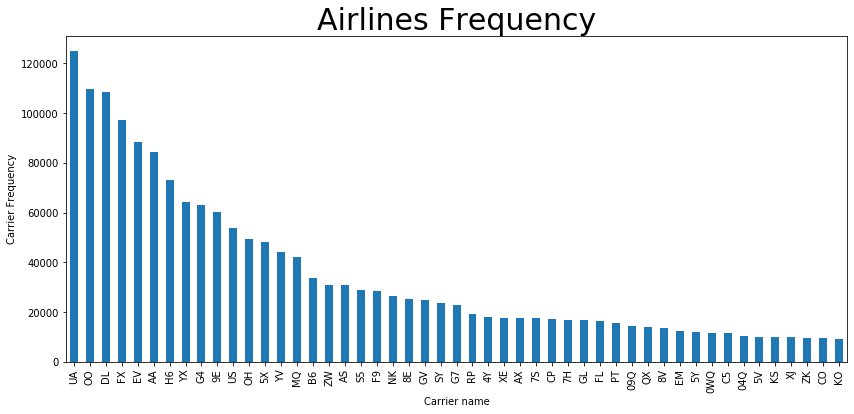

In [50]:
fig, ax = plt.subplots(figsize=(14,6))

t100dm['unique_carrier'].value_counts()[1:50].plot('bar')
plt.title('Airlines Frequency' , fontsize=30)
ax.set(xlabel = 'Carrier name', ylabel='Carrier Frequency')
plt.show()

In [13]:
# Separate the origin and destination in two different tables
t100dm1 = t100dm[['quarter','airline_id','unique_carrier','unique_carrier_name','citymarket1_id','citymarket2_id','state1','state2']]

t100dm2 = t100dm[['quarter','airline_id','unique_carrier','unique_carrier_name','citymarket1_id','citymarket2_id','state1','state2']]


In [14]:
# Rename the columns of the the destination
t100dm2.columns = ['quarter','airline_id','unique_carrier','unique_carrier_name',
                   'citymarket2_id','citymarket1_id','state2','state1']

In [15]:
t100dm1.head()

,quarter,airline_id,unique_carrier,unique_carrier_name,citymarket1_id,citymarket2_id,state1,state2
0,2018Q4,19393.0,WN,Southwest Airlines Co.,31703,33495,New Jersey,Louisiana
1,2018Q4,19393.0,WN,Southwest Airlines Co.,32467,30994,Florida,South Carolina
2,2018Q4,19393.0,WN,Southwest Airlines Co.,31871,30977,South Carolina,Illinois
3,2018Q4,19393.0,WN,Southwest Airlines Co.,30852,30559,Virginia,Washington
4,2018Q4,19393.0,WN,Southwest Airlines Co.,30928,30194,Kansas,Texas


In [16]:
t100dm2.head()

,quarter,airline_id,unique_carrier,unique_carrier_name,citymarket2_id,citymarket1_id,state2,state1
0,2018Q4,19393.0,WN,Southwest Airlines Co.,31703,33495,New Jersey,Louisiana
1,2018Q4,19393.0,WN,Southwest Airlines Co.,32467,30994,Florida,South Carolina
2,2018Q4,19393.0,WN,Southwest Airlines Co.,31871,30977,South Carolina,Illinois
3,2018Q4,19393.0,WN,Southwest Airlines Co.,30852,30559,Virginia,Washington
4,2018Q4,19393.0,WN,Southwest Airlines Co.,30928,30194,Kansas,Texas


In [17]:
# Merge the tables
t100dm1_t100dm2 = pd.concat([t100dm1,t100dm2], axis=0, sort=True)
t100dm1_t100dm2.dropna(inplace=True)

t100dm1_t100dm2.head()

,airline_id,citymarket1_id,citymarket2_id,quarter,state1,state2,unique_carrier,unique_carrier_name
0,19393.0,31703,33495,2018Q4,New Jersey,Louisiana,WN,Southwest Airlines Co.
1,19393.0,32467,30994,2018Q4,Florida,South Carolina,WN,Southwest Airlines Co.
2,19393.0,31871,30977,2018Q4,South Carolina,Illinois,WN,Southwest Airlines Co.
3,19393.0,30852,30559,2018Q4,Virginia,Washington,WN,Southwest Airlines Co.
4,19393.0,30928,30194,2018Q4,Kansas,Texas,WN,Southwest Airlines Co.


In [18]:
(t100dm1_t100dm2.shape[0],t100dm1.shape[0]+t100dm2.shape[0])

(4569246, 4569962)

In [19]:
# Count the number of airline
competitors = t100dm1_t100dm2.groupby(['quarter','citymarket1_id', 'citymarket2_id','state1','state2'
                                      ])['unique_carrier'].agg(['count', 'nunique'])
competitors.head()

count  nunique
quarter citymarket1_id citymarket2_id state1 state2                
2010Q1  30003          35478          Alaska Alaska      1        1
        30009          30009          Alaska Alaska     10        3
                       30036          Alaska Alaska      9        1
                       30070          Alaska Alaska      3        1
                       30096          Alaska Alaska      6        1

In [20]:
# Reset the index, rename the new columns and sort the data 
competitors.reset_index(inplace=True)
competitors.rename(columns={'count': 'count_arline','nunique':'nb_airline'}, inplace=True)
competitors.sort_values(['quarter', 'citymarket1_id', 'citymarket2_id'],inplace=True)
competitors.head()

,quarter,citymarket1_id,citymarket2_id,state1,state2,count_arline,nb_airline
0,2010Q1,30003,35478,Alaska,Alaska,1,1
1,2010Q1,30009,30009,Alaska,Alaska,10,3
2,2010Q1,30009,30036,Alaska,Alaska,9,1
3,2010Q1,30009,30070,Alaska,Alaska,3,1
4,2010Q1,30009,30096,Alaska,Alaska,6,1


In [21]:
competitors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558075 entries, 0 to 558074
Data columns (total 7 columns):
quarter           558075 non-null period[Q-DEC]
citymarket1_id    558075 non-null int64
citymarket2_id    558075 non-null int64
state1            558075 non-null object
state2            558075 non-null object
count_arline      558075 non-null int64
nb_airline        558075 non-null int64
dtypes: int64(4), object(2), period[Q-DEC](1)
memory usage: 34.1+ MB


In [22]:
competitors.nb_airline.unique()

array([ 1,  3,  4,  2,  7,  8,  6,  5, 10, 14, 12,  9, 13, 11, 16, 17, 15,
       20, 18, 19, 21, 23, 22, 26, 25])

In [23]:
competitors.loc[(competitors.citymarket1_id==30135) &(competitors.citymarket2_id==30721) & (competitors.quarter=='2010Q3')]

,quarter,citymarket1_id,citymarket2_id,state1,state2,count_arline,nb_airline
34359,2010Q3,30135,30721,Pennsylvania,Massachusetts,1,1
34360,2010Q3,30135,30721,Pennsylvania,New Hampshire,1,1
34361,2010Q3,30135,30721,Pennsylvania,Rhode Island,1,1


In [24]:
competitors.loc[(competitors.quarter==competitors.quarter.shift()) & 
                ((competitors.state1!=competitors.state1.shift()) |
                (competitors.state2!=competitors.state2.shift())) &
                (competitors.citymarket1_id==competitors.citymarket1_id.shift()) &
                (competitors.citymarket2_id==competitors.citymarket2_id.shift()), 
                'bad'] = 1

competitors = competitors.loc[competitors.bad!=1]
competitors.drop('bad', axis=1, inplace=True)
competitors.head()

,quarter,citymarket1_id,citymarket2_id,state1,state2,count_arline,nb_airline
0,2010Q1,30003,35478,Alaska,Alaska,1,1
1,2010Q1,30009,30009,Alaska,Alaska,10,3
2,2010Q1,30009,30036,Alaska,Alaska,9,1
3,2010Q1,30009,30070,Alaska,Alaska,3,1
4,2010Q1,30009,30096,Alaska,Alaska,6,1


In [25]:
print("The 'competitors' table contains informations from '{}' to '{}'.".format(competitors.quarter.dt.year.min(), competitors.quarter.dt.year.max()))


The 'competitors' table contains informations from '2010' to '2018'.


### Merging the two datasets:
- Merge the data by quarter, city market id, state id
- Drop directly the non matching informations by using inner join
    - Since the `competitors` table only contains information from 2010 to 2018, the data in the `airfare_info` table over the other periods will be deleted.

In [26]:
# Merge
air_df = pd.merge(airfare_info, competitors, on=['quarter','citymarket1_id','citymarket2_id'], how='inner')

print("The 'air_df' dataset has '{}' observations and '{}' variables.".format(air_df.shape[0], air_df.shape[1]))
print("The period is from '{}' to '{}'.".format(air_df.quarter.dt.year.min(), air_df.quarter.dt.year.max()))


The 'air_df' dataset has '108806' observations and '18' variables.
The period is from '2010' to '2018'.


## <font color='green'> **Personal Income and Population**  
We also need the `budget of the passenger and the number of the population`.
- Because the level of income also influences an individual's consumption behaviour: the higher the income, the greater an individual's expenditure. Personal income per state will be used to approximate this this passenger budget.  
- The number of passengers from one city to another also depends on the size of these cities, in terms of population. All other things being equal, transport movements are much important in large cities than in small cities.  
- These two variables ([per capita personal income and population](https://apps.bea.gov/itable/iTable.cfm?ReqID=70&step=1)) are downloaded from the [Bureau of Economics Analysis](https://www.bea.gov) website. 
    
**`Note that`** The data about population was available only from 2010. 

### Read the data

In [27]:
population_income = pd.read_csv('../regional_data/population_income.csv', header=4)
population_income.drop(['GeoFips','LineCode'], axis=1, inplace=True)
population_income.head(3)

,GeoName,Description,2009:Q1,2009:Q2,2009:Q3,2009:Q4,2010:Q1,2010:Q2,2010:Q3,2010:Q4,...,2017:Q1,2017:Q2,2017:Q3,2017:Q4,2018:Q1,2018:Q2,2018:Q3,2018:Q4,2019:Q1,2019:Q2
0,United States,"Personal income (millions of dollars, seasonal...",11984222.0,12074284.0,12028785.5,12117936.5,12264621.9,12484065.5,12628031.1,12791261.5,...,16599641.3,16742829.8,16918886.7,17219066.2,17535505.2,17720035.9,17918889.1,18077709.8,18352749.2,18596160.0
1,United States,"Population (midperiod, persons) 1/",(NA),(NA),(NA),(NA),308468490.0,309037543.0,309658448.0,310273873.0,...,324428802.0,324882608.0,325440089.0,325982976.0,326432971.0,326901436.0,327461014.0,328000894.0,328441065.0,328898168.0
2,United States,Per capita personal income (dollars) 2/,(NA),(NA),(NA),(NA),39760.0,40397.0,40781.0,41226.0,...,51166.0,51535.0,51988.0,52822.0,53719.0,54206.0,54721.0,55115.0,55878.0,56541.0


### Transpose the table

In [28]:
pop_income = population_income.pivot_table(columns = ["GeoName"], index = "Description").transpose() # To panel data
pop_income.reset_index(inplace= True)
pop_income.columns = ['quarter', 'state','income_capita', 'income', 'population']

# Process and rename the columns
pop_income['state'] = pop_income.state.str.replace('*', '')
pop_income['quarter'] = pd.to_datetime(pop_income.quarter.str.replace(':Q', 'q')).dt.to_period('Q-DEC')

pop_income.head()

,quarter,state,income_capita,income,population
0,2010Q1,Alabama,33061.0,157933.1,4777058.0
1,2010Q1,Alaska,48687.0,34492.2,708450.0
2,2010Q1,Arizona,33086.0,211253.0,6385009.0
3,2010Q1,Arkansas,31149.0,90743.7,2913213.0
4,2010Q1,California,42839.0,1594061.6,37210654.0


## <font color='green'> **Jet Fuel**  

The table [Kerosene and Jet Fuels](https://fred.stlouisfed.org/series/WPU0572) is downloaded from the [Producer Price Index by Commodity for Fuels and Related Products and Power](https://fred.stlouisfed.org/tags/series?t=fuels%3Bkerosene%3Bprice&ob=pv&od=desc) data of the [Federal Reserve Bank of St. Louis](https://research.stlouisfed.org).

### Read the data

In [29]:
kerosene_JetFuels = pd.read_csv('../ Kerosene_JetFuels.csv')
kerosene_JetFuels.head()

,DATE,WPU0572
0,1970-02-01,10.3
1,1970-03-01,10.3
2,1970-04-01,10.3
3,1970-05-01,10.3
4,1970-06-01,10.2


### Group the data by quarter:
- Since the data is available by month, we calculate the average values by quarter.


In [30]:
date = []
for d in kerosene_JetFuels.DATE:
    date.append(dt.datetime.strptime(d, "%Y-%m-%d"))
    
kerosene_JetFuels['DATE'] = date
kerosene_jetfuels = kerosene_JetFuels.groupby(pd.Grouper(key='DATE', freq='1Q'))['WPU0572', 'WPU0572'].mean()
kerosene_jetfuels.reset_index(inplace=True)
kerosene_jetfuels.columns = ['quarter','kjf_price','WPU0572']
kerosene_jetfuels['quarter'] = pd.PeriodIndex(kerosene_jetfuels['quarter'])
kerosene_jetfuels.drop('WPU0572', axis=1, inplace=True)
kerosene_jetfuels.tail()

,quarter,kjf_price
195,2018Q4,224.500000
196,2019Q1,196.166667
197,2019Q2,210.300000
198,2019Q3,199.966667
199,2019Q4,202.800000


### Cheche the evolution price of jut fuels

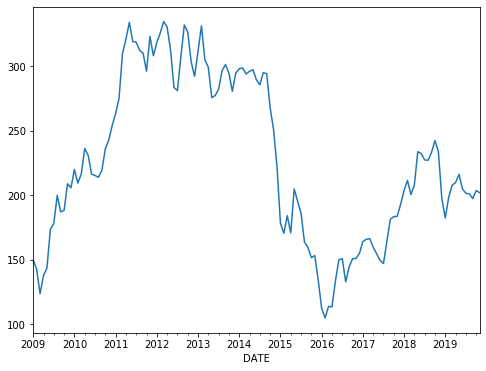

In [31]:
kerosene_JetFuels[kerosene_JetFuels.DATE.dt.year>=2009
                 ].groupby(pd.Grouper(key='DATE', freq='1M'))['WPU0572'].mean().plot(y='WPU0572', figsize=(8,6))

### Merge the data

In [32]:
# Merge the data
pi_kjf = pd.merge(pop_income, kerosene_jetfuels, how='inner', on='quarter')

# Check if there are any null data
print('Is there a missing value?', pi_kjf.isnull().values.any())

# Show some observations
pi_kjf.loc[12:17]

Is there a missing value? False


,quarter,state,income_capita,income,population,kjf_price
12,2010Q1,Great Lakes,37116.0,1722852.8,46418415.0,215.266667
13,2010Q1,Hawaii,41263.0,56044.2,1358222.0,215.266667
14,2010Q1,Idaho,31318.0,49034.4,1565677.0,215.266667
15,2010Q1,Illinois,41219.0,528734.8,12827387.0,215.266667
16,2010Q1,Indiana,34690.0,224817.2,6480787.0,215.266667
17,2010Q1,Iowa,37371.0,113792.1,3044938.0,215.266667


## <font color='green'> **Final dataset**  
- Because we have two cities per line, the table about `income` and `population` data will be joined twice in order to dissociate `city1` from `city2`.
    - Rename `city` to `city1` and merge this last one with the other data by `quarter` and `city1` (only matching cities will be mapped)
    - Rename again `city` to `city2` and merge this last one with the other data by `quarter` and `city2` (again, only matching cities will be mapped)
- Calculate the average of the `income`, the `population per capita` and the `population` of the two cities of the corresponding line.  

In [33]:
## Merge the data
pi_kjf.rename(columns = {'state':'state1'}, inplace = True)
air_in = pd.merge(air_df, pi_kjf, on=['quarter', 'state1'], how='inner')

pi_kjf.rename(columns = {'state1':'state2'}, inplace = True)
df = pd.merge(air_in, pi_kjf, on=['quarter', 'state2', 'kjf_price'], how='inner')

# Take the average of the income and the population of the two cities (origin and destination cities)
df['income'] = df[['income_x', 'income_y']].mean(axis=1)
df['income_capita'] = df[['income_capita_x', 'income_capita_y']].mean(axis=1)
df['population'] = df[['population_x', 'population_y']].mean(axis=1)

df.drop(['income_x', 'income_y', 'income_capita_x', 'income_capita_y', 'population_x', 'population_y'], axis=1, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108806 entries, 0 to 108805
Data columns (total 22 columns):
quarter            108806 non-null period[Q-DEC]
citymarket1_id     108806 non-null int64
citymarket2_id     108806 non-null int64
city1_name         108806 non-null object
city2_name         108806 non-null object
nsmiles            108806 non-null int64
passengers         108806 non-null int64
fare               108806 non-null float64
latitude_city1     108806 non-null float64
longitude_city1    108806 non-null float64
latitude_city2     108806 non-null float64
longitude_city2    108806 non-null float64
state1_code        108806 non-null object
state2_code        108806 non-null object
state1             108806 non-null object
state2             108806 non-null object
count_arline       108806 non-null int64
nb_airline         108806 non-null int64
kjf_price          108806 non-null float64
income             108806 non-null float64
income_capita      108806 non-null float6

In [34]:
df.head()

,quarter,citymarket1_id,citymarket2_id,city1_name,city2_name,nsmiles,passengers,fare,latitude_city1,longitude_city1,...,state1_code,state2_code,state1,state2,count_arline,nb_airline,kjf_price,income,income_capita,population
0,2013Q2,31650,34685,Minneapolis/St. Paul,Savannah,1092,103,222.88,44.977479,-93.264346,...,MN,GA,Minnesota,Georgia,1,1,283.933333,315969.85,42626.0,7686375.5
1,2013Q2,33244,34685,Memphis,Savannah,544,23,323.93,35.143378,-90.052136,...,TN,GA,Tennessee,Georgia,11,3,283.933333,314447.40,38420.0,8225959.0
2,2013Q2,31703,34685,New York City,Savannah,756,458,246.19,40.123164,-75.333718,...,NY,GA,New Jersey,Georgia,6,1,283.933333,434539.65,46719.0,9410316.0
3,2013Q2,30792,34685,Buffalo,Savannah,758,35,220.82,39.945422,-78.646710,...,NY,GA,New York,Georgia,4,2,283.933333,720780.55,45964.0,14792507.5
4,2013Q2,30257,30397,Albany,Atlanta,853,188,280.26,42.651242,-73.755418,...,NY,GA,New York,Georgia,18,5,283.933333,720780.55,45964.0,14792507.5


In [35]:
df.sort_values(['citymarket1_id','citymarket2_id','quarter']
              )[['citymarket1_id','citymarket2_id','quarter',
                 'passengers','fare','population','income_capita',
                 'nb_airline','kjf_price',]].head()

,citymarket1_id,citymarket2_id,quarter,passengers,fare,population,income_capita,nb_airline,kjf_price
10381,30135,30194,2010Q1,28,214.94,18895427.5,39195.5,2,215.266667
36194,30135,30194,2010Q2,42,235.15,18950379.5,39913.0,1,227.833333
60901,30135,30194,2010Q4,64,189.38,19065444.0,40984.5,1,244.200000
29804,30135,30194,2011Q3,47,243.50,19227152.0,43041.5,1,313.600000
13848,30135,30194,2012Q2,39,275.34,19399163.0,44576.0,2,308.700000


In [36]:
sorted(df.quarter.unique())

[Period('2010Q1', 'Q-DEC'),
 Period('2010Q2', 'Q-DEC'),
 Period('2010Q3', 'Q-DEC'),
 Period('2010Q4', 'Q-DEC'),
 Period('2011Q1', 'Q-DEC'),
 Period('2011Q2', 'Q-DEC'),
 Period('2011Q3', 'Q-DEC'),
 Period('2011Q4', 'Q-DEC'),
 Period('2012Q1', 'Q-DEC'),
 Period('2012Q2', 'Q-DEC'),
 Period('2012Q3', 'Q-DEC'),
 Period('2012Q4', 'Q-DEC'),
 Period('2013Q1', 'Q-DEC'),
 Period('2013Q2', 'Q-DEC'),
 Period('2013Q3', 'Q-DEC'),
 Period('2013Q4', 'Q-DEC'),
 Period('2014Q1', 'Q-DEC'),
 Period('2014Q2', 'Q-DEC'),
 Period('2014Q3', 'Q-DEC'),
 Period('2014Q4', 'Q-DEC'),
 Period('2015Q1', 'Q-DEC'),
 Period('2015Q2', 'Q-DEC'),
 Period('2015Q3', 'Q-DEC'),
 Period('2015Q4', 'Q-DEC'),
 Period('2016Q1', 'Q-DEC'),
 Period('2016Q2', 'Q-DEC'),
 Period('2016Q3', 'Q-DEC'),
 Period('2016Q4', 'Q-DEC'),
 Period('2017Q1', 'Q-DEC'),
 Period('2017Q2', 'Q-DEC'),
 Period('2017Q3', 'Q-DEC'),
 Period('2017Q4', 'Q-DEC'),
 Period('2018Q1', 'Q-DEC')]

## Data Visualization

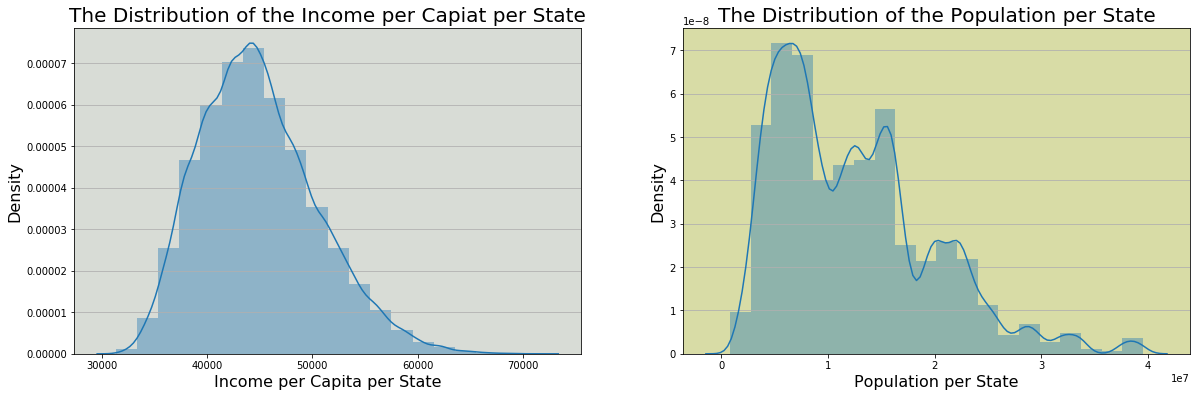

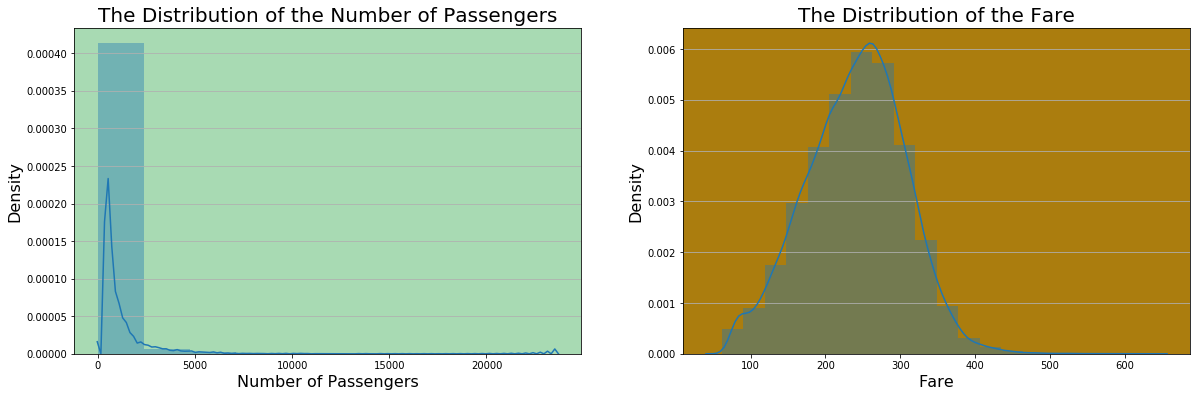

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.distplot(df.income_capita, bins=20, ax=ax1)
ax1.set_title(label = 'The Distribution of the Income per Capiat per State', fontsize = 20)
ax1.set_xlabel(xlabel = 'Income per Capita per State', fontsize = 16)
ax1.set_ylabel(ylabel = 'Density', fontsize = 16)
ax1.grid(axis='y'); ax1.set_facecolor('#d8dcd6')

sns.distplot(df.population, bins=20, ax=ax2)
ax2.set_title(label = 'The Distribution of the Population per State', fontsize = 20)
ax2.set_xlabel(xlabel = 'Population per State', fontsize = 16)
ax2.set_ylabel(ylabel = 'Density', fontsize = 16)
ax2.grid(axis='y'); ax2.set_facecolor('#d8dca6')
plt.show()

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 6))

sns.distplot(df.passengers, bins=10, ax=ax3)
ax3.set_title(label = 'The Distribution of the Number of Passengers', fontsize = 20)
ax3.set_xlabel(xlabel = 'Number of Passengers', fontsize = 16)
ax3.set_ylabel(ylabel = 'Density', fontsize = 16)
ax3.grid(axis='y'); ax3.set_facecolor('#a8dab3')

sns.distplot(df.fare, bins=20, ax=ax4)
ax4.set_title(label = 'The Distribution of the Fare', fontsize = 20)
ax4.set_xlabel(xlabel = 'Fare', fontsize = 16)
ax4.set_ylabel(ylabel = 'Density', fontsize = 16)
ax4.grid(axis='y'); ax4.set_facecolor('#ab7d0e')
plt.show()

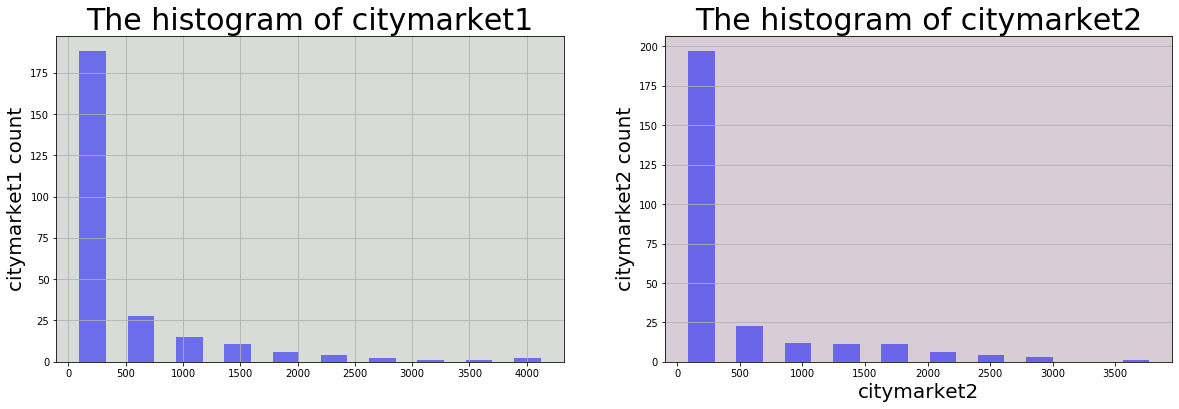

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

df.citymarket1_id.value_counts().hist(rwidth=0.55, alpha=0.5, color= 'blue', ax=ax1)
ax1.set_title(label = 'The histogram of citymarket1', fontsize = 30)
ax1.set_ylabel('citymarket1 count' , fontsize = 20); plt.xlabel('citymarket1', fontsize = 20)
plt.grid(axis='x'); ax1.set_facecolor('#d8dcd6')

df.citymarket2_id.value_counts().hist(rwidth=0.55, alpha=0.5, color= 'blue', ax=ax2)
ax2.set_title(label = 'The histogram of citymarket2', fontsize = 30)
ax2.set_ylabel('citymarket2 count' , fontsize = 20); plt.xlabel('citymarket2', fontsize = 20)
plt.grid(axis='x'); ax2.set_facecolor('#d8ccd6')


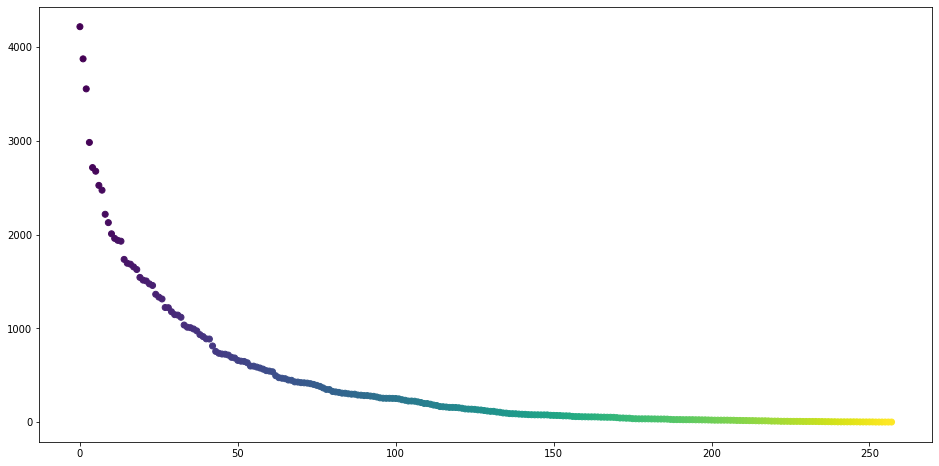

In [39]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.scatter(range(258), df.citymarket1_id.value_counts(), c=range(258))
plt.show()

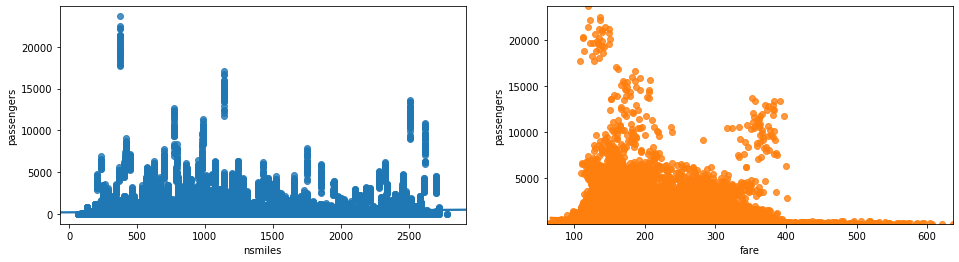

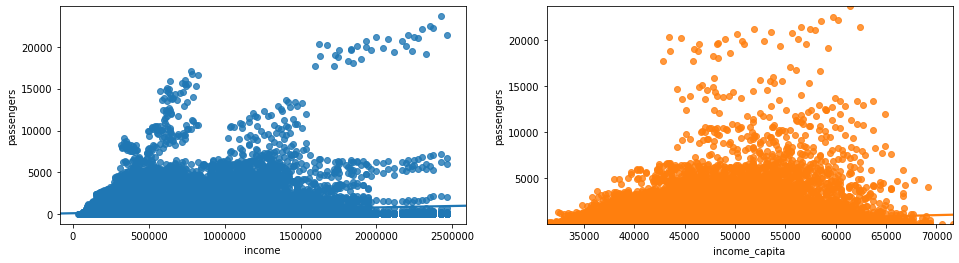

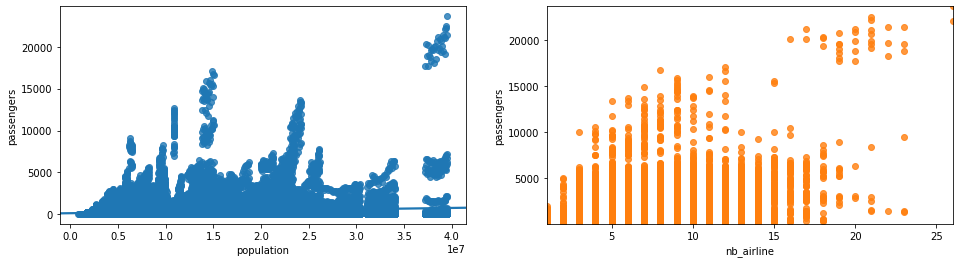

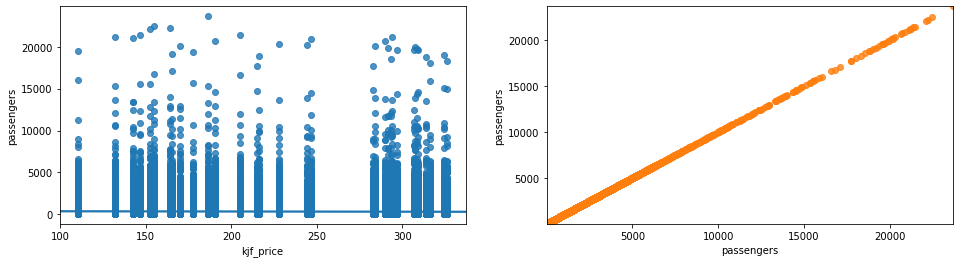

In [37]:
l = 0
for length in range(4):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    variables = ['nsmiles','fare','income','income_capita','population','nb_airline','kjf_price','passengers']

    for i, j in zip((ax1, ax2), variables[l:l+2]):
        sns.regplot(data=df, x=j, y='passengers', ax=i, fit_reg=True)
        plt.xlim(df[j].min(), df[j].max())
        plt.ylim(df.passengers.min(), df.passengers.max())
        
    l+=2

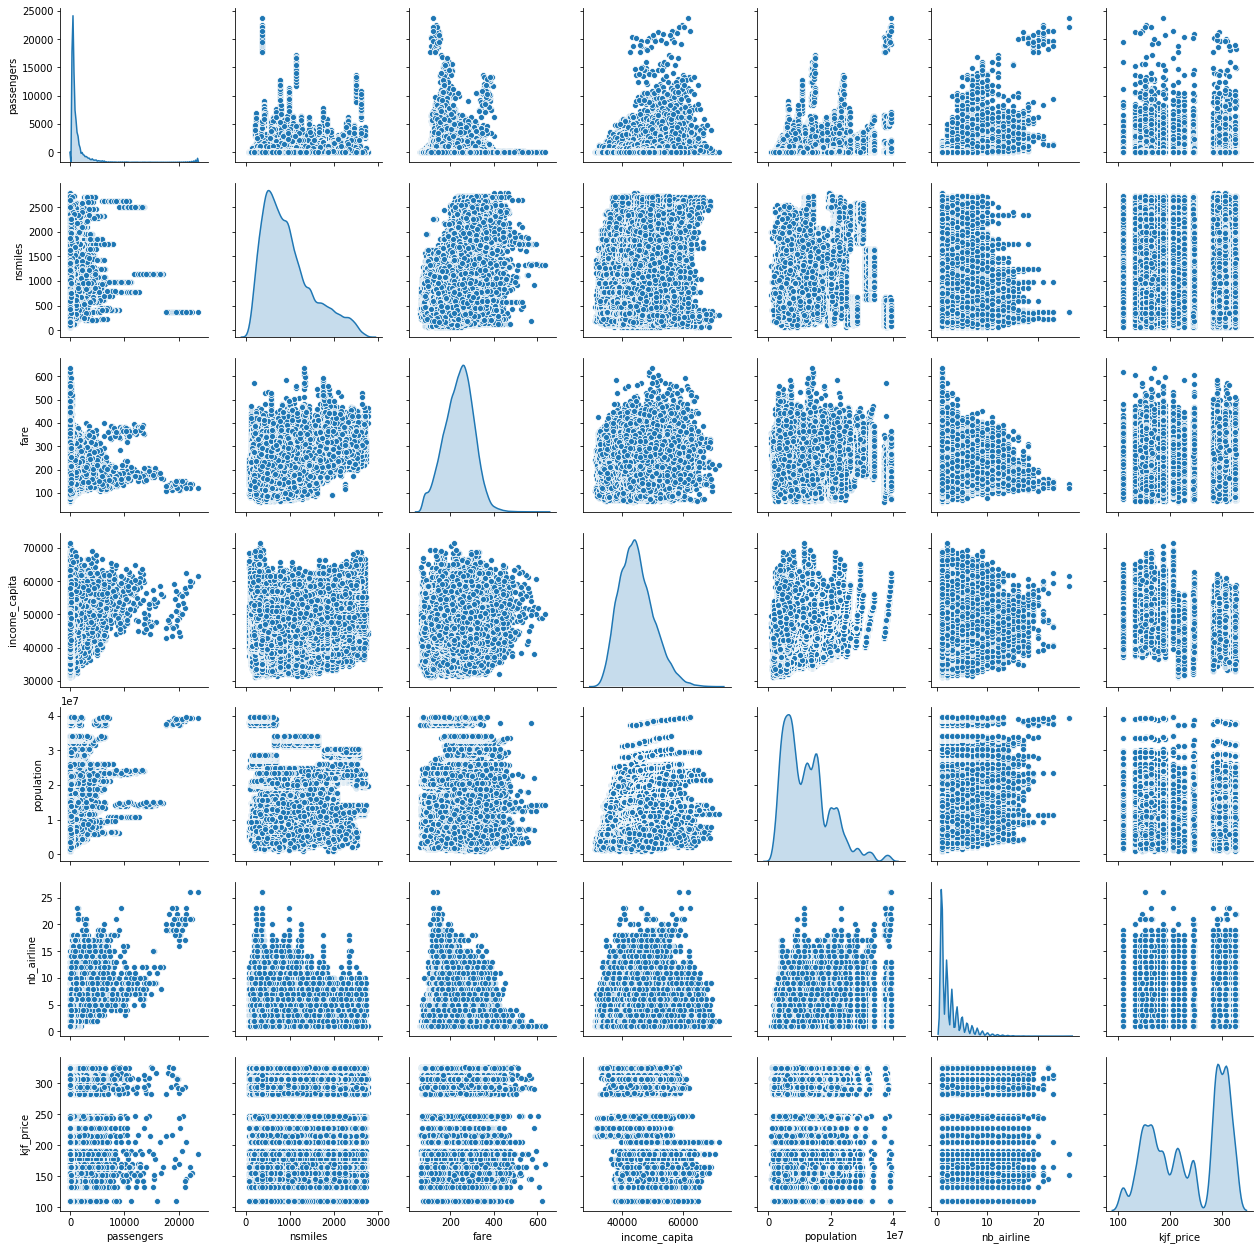

In [44]:
sns.pairplot(df[['passengers', 'nsmiles','fare','income_capita','population',
                 'nb_airline','kjf_price']], diag_kind="kde")
plt.show()

# Descriptive statistics

In [40]:
variables = ['passengers','nsmiles','fare', 'income', 'income_capita','population','kjf_price','nb_airline']

df[variables].describe(percentiles = [0.10,0.125,0.25,0.50,0.75,0.85,0.90,0.95,.97])

,passengers,nsmiles,fare,income,income_capita,population,kjf_price,nb_airline
count,108806.000000,108806.000000,108806.000000,1.088060e+05,108806.000000,1.088060e+05,108806.000000,108806.000000
mean,302.355440,958.501792,240.484724,5.765340e+05,44894.675468,1.239174e+07,236.688392,2.806702
std,846.462331,567.377301,66.456245,3.759327e+05,5591.352933,7.308291e+06,67.400067,2.491935
min,10.000000,67.000000,61.190000,3.455730e+04,31318.000000,8.081990e+05,110.433333,1.000000
10%,16.000000,345.000000,151.530000,1.859895e+05,38032.000000,4.356252e+06,146.400000,1.000000
12.5%,18.000000,379.000000,160.740000,2.039802e+05,38556.500000,4.739619e+06,152.233333,1.000000
25%,30.000000,524.000000,195.470000,2.852308e+05,40784.500000,6.483876e+06,169.733333,1.000000
50%,75.000000,832.000000,244.275000,4.913460e+05,44354.000000,1.129782e+07,244.200000,2.000000
75%,218.000000,1254.000000,286.290000,7.615927e+05,48358.500000,1.629693e+07,296.800000,4.000000
85%,440.000000,1593.000000,307.680000,9.652865e+05,50852.000000,2.050301e+07,309.066667,5.000000


In [45]:
df.select_dtypes(include=['object']).head()

,city1_name,city2_name,state1_code,state2_code,state1,state2
0,Minneapolis/St. Paul,Savannah,MN,GA,Minnesota,Georgia
1,Memphis,Savannah,TN,GA,Tennessee,Georgia
2,New York City,Savannah,NY,GA,New Jersey,Georgia
3,Buffalo,Savannah,NY,GA,New York,Georgia
4,Albany,Atlanta,NY,GA,New York,Georgia


In [42]:
def detecting_outliers(x):
    
    inf_bound = x.loc['25%']-5*(x.loc['75%']-x.loc['25%'])
    sup_bound = x.loc['25%']+5*(x.loc['75%']-x.loc['25%'])

    return inf_bound,sup_bound

stats = df[variables].describe(percentiles = [0.05,0.25,0.50,0.75,0.95])

index = ['inf_bound','sup_bound']
df_stats = pd.DataFrame({'index': index})

for j in variables:
    values = pd.DataFrame(np.round(detecting_outliers(stats[j]),3))[0]
    var_name = str(j)
    df_stats[var_name] = values

bound = []
for j in variables:
    bound.append(np.array(np.round(detecting_outliers(stats[j]),3)))

df_stats = df_stats.set_index('index')
df_stats

,passengers,nsmiles,fare,income,income_capita,population,kjf_price,nb_airline
index,,,,,,,,
inf_bound,-910.0,-3126.0,-258.63,-2096578.30,2914.5,-42581371.0,-465.600,-14.0
sup_bound,970.0,4174.0,649.57,2667039.95,78654.5,55549124.0,805.067,16.0


In [43]:
df = df.loc[((df.passengers > df_stats.passengers.loc['inf_bound']) & (df.passengers < df_stats.passengers.loc['sup_bound'])) &
            ((df.nsmiles > df_stats.nsmiles.loc['inf_bound']) & (df.nsmiles < df_stats.nsmiles.loc['sup_bound'])) &
            ((df.fare > df_stats.fare.loc['inf_bound']) & (df.fare < df_stats.fare.loc['sup_bound'])) &
            ((df.income > df_stats.income.loc['inf_bound']) & (df.income < df_stats.income.loc['sup_bound'])) &
            ((df.income_capita > df_stats.income_capita.loc['inf_bound']) & (df.income_capita < df_stats.income_capita.loc['sup_bound'])) & 
            ((df.population > df_stats.population.loc['inf_bound']) & (df.population < df_stats.population.loc['sup_bound'])) &
            ((df.kjf_price > df_stats.kjf_price.loc['inf_bound']) & (df.kjf_price < df_stats.kjf_price.loc['sup_bound'])) &
            ((df.nb_airline > df_stats.nb_airline.loc['inf_bound']) & (df.nb_airline < df_stats.nb_airline.loc['sup_bound']))]
df.shape

(101236, 22)

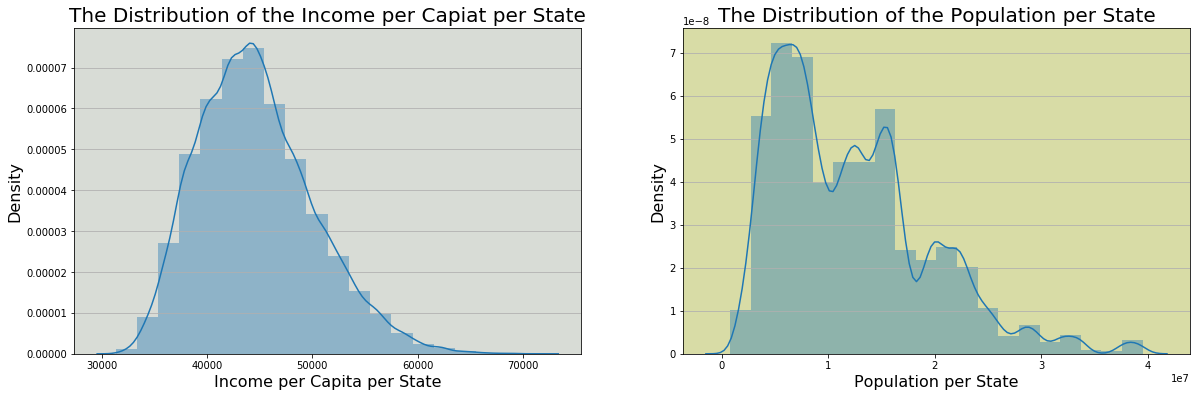

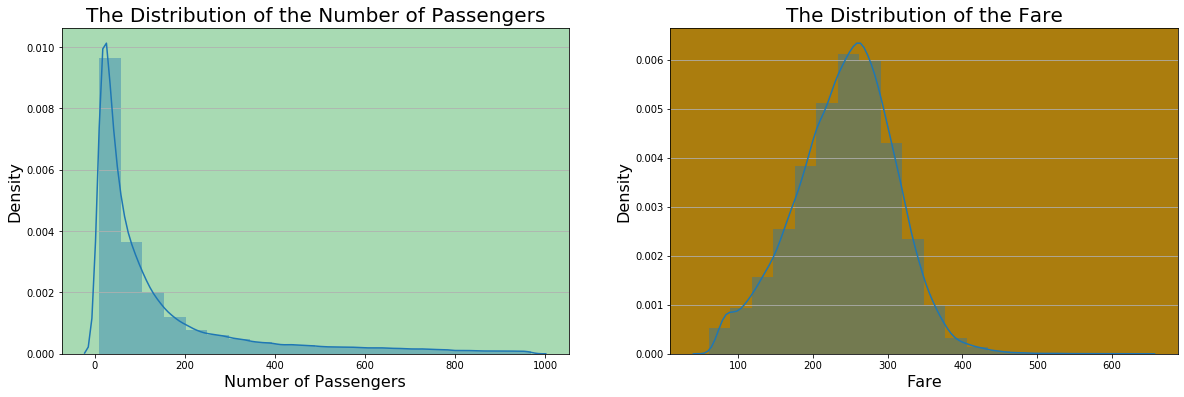

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.distplot(df.income_capita, bins=20, ax=ax1)
ax1.set_title(label = 'The Distribution of the Income per Capiat per State', fontsize = 20)
ax1.set_xlabel(xlabel = 'Income per Capita per State', fontsize = 16)
ax1.set_ylabel(ylabel = 'Density', fontsize = 16)
ax1.grid(axis='y'); ax1.set_facecolor('#d8dcd6')

sns.distplot(df.population, bins=20, ax=ax2)
ax2.set_title(label = 'The Distribution of the Population per State', fontsize = 20)
ax2.set_xlabel(xlabel = 'Population per State', fontsize = 16)
ax2.set_ylabel(ylabel = 'Density', fontsize = 16)
ax2.grid(axis='y'); ax2.set_facecolor('#d8dca6')
plt.show()

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 6))

sns.distplot(df.passengers, bins=20, ax=ax3)
ax3.set_title(label = 'The Distribution of the Number of Passengers', fontsize = 20)
ax3.set_xlabel(xlabel = 'Number of Passengers', fontsize = 16)
ax3.set_ylabel(ylabel = 'Density', fontsize = 16)
ax3.grid(axis='y'); ax3.set_facecolor('#a8dab3')

sns.distplot(df.fare, bins=20, ax=ax4)
ax4.set_title(label = 'The Distribution of the Fare', fontsize = 20)
ax4.set_xlabel(xlabel = 'Fare', fontsize = 16)
ax4.set_ylabel(ylabel = 'Density', fontsize = 16)
ax4.grid(axis='y'); ax4.set_facecolor('#ab7d0e')
plt.show()

In [45]:
df[variables].describe(percentiles = [0.10,0.25,0.50,0.75,0.90,0.97])


,passengers,nsmiles,fare,income,income_capita,population,kjf_price,nb_airline
count,101236.000000,101236.000000,101236.000000,1.012360e+05,101236.000000,1.012360e+05,101236.000000,101236.000000
mean,141.824203,947.956142,243.266215,5.654192e+05,44656.626837,1.220159e+07,237.052653,2.463669
std,185.653936,560.142105,66.402375,3.701666e+05,5505.564280,7.220181e+06,67.341462,2.024640
min,10.000000,67.000000,61.190000,3.455730e+04,31318.000000,8.081990e+05,110.433333,1.000000
10%,16.000000,343.000000,153.670000,1.819356e+05,37908.000000,4.280504e+06,146.400000,1.000000
25%,28.000000,519.000000,200.450000,2.790622e+05,40627.000000,6.410836e+06,169.733333,1.000000
50%,65.000000,818.000000,247.580000,4.808898e+05,44165.500000,1.114120e+07,244.200000,2.000000
75%,164.000000,1240.000000,288.300000,7.469171e+05,48074.500000,1.615892e+07,296.800000,3.000000
90%,395.000000,1823.000000,323.570000,1.095144e+06,52135.250000,2.222719e+07,313.600000,5.000000
95%,593.000000,2122.000000,345.090000,1.283397e+06,54664.500000,2.530448e+07,324.566667,7.000000


In [46]:
df.loc[df.passengers>=969]

,quarter,citymarket1_id,citymarket2_id,city1_name,city2_name,nsmiles,passengers,fare,latitude_city1,longitude_city1,...,state1_code,state2_code,state1,state2,count_arline,nb_airline,kjf_price,income,income_capita,population
1822,2013Q2,31650,30559,Minneapolis/St. Paul,Seattle,1399,969,243.40,44.977479,-93.264346,...,MN,WA,Minnesota,Washington,29,6,283.933333,296079.85,47882.5,6181287.5
17498,2013Q3,32211,34570,Las Vegas,Reno,345,969,156.48,36.169202,-115.140597,...,NV,NV,Nevada,Nevada,22,4,293.300000,109369.80,39305.0,2782583.0
39147,2014Q2,30325,31123,Denver,St. Louis,770,969,176.75,39.738453,-104.984853,...,CO,MO,Colorado,Missouri,35,9,294.200000,260556.05,46008.5,5697625.0
40730,2014Q4,34100,30466,Philadelphia,Phoenix,2075,969,279.49,39.951061,-75.165620,...,PA,AZ,Pennsylvania,Arizona,25,6,246.866667,446846.75,44051.5,9784030.5
48120,2014Q1,32575,31123,Los Angeles,St. Louis,1592,969,256.80,34.052238,-118.243344,...,CA,MO,California,Missouri,41,5,296.800000,1104608.85,45915.5,22277387.5
68596,2017Q1,30194,30693,Dallas/Fort Worth,Nashville,631,969,209.98,40.110860,-77.035636,...,TX,TN,Texas,Tennessee,22,10,165.466667,812104.00,45833.0,17434711.5
94049,2016Q4,31057,32575,Charlotte,Los Angeles,2125,969,331.19,35.222936,-80.840161,...,NC,CA,North Carolina,California,23,6,152.233333,1369882.50,50812.5,24748751.0
103201,2017Q4,30325,30693,Denver,Nashville,1014,969,187.30,39.738453,-104.984853,...,CO,TN,Colorado,Tennessee,25,7,186.666667,312950.95,51039.5,6190068.0


In [47]:
df['citymarket_id'] = df.citymarket1_id.astype(str)+'_'+df.citymarket2_id.astype(str)
df.sort_values(['citymarket_id','quarter'], inplace=True)
print('We have {} uniques cities pair markets and {} periods on our dataset'.format(df.citymarket_id.nunique(),
                                                                                    df.quarter.nunique()))

We have 6006 uniques cities pair markets and 33 periods on our dataset


In [48]:
# Creating a dummy variables of quarter
df['dum_q1'] = [1 if i==1 else 0 for i in df.quarter.dt.quarter]
df['dum_q2'] = [1 if i==2 else 0 for i in df.quarter.dt.quarter]
df['dum_q3'] = [1 if i==3 else 0 for i in df.quarter.dt.quarter]
df['dum_q4'] = [1 if i==4 else 0 for i in df.quarter.dt.quarter]

# Create a dummy from the distance variable for the train competitors
df['dum_dist'] = [1 if d < 150 else 0 for d in df.nsmiles]

# Create a log function
df['log_passengers'] = np.log(df['passengers'])
df['log_nsmiles'] = np.log(df['nsmiles'])
df['log_fare'] = np.log(df['fare'])
df['log_income'] = np.log(df['income'])
df['log_income_capita'] = np.log(df['income_capita'])
df['log_population'] = np.log(df['population'])
df['log_kjf_price'] = np.log(df['kjf_price'])

df[['quarter','dum_q1','dum_q2','dum_q3','dum_q4','log_passengers','log_income_capita','log_nsmiles']].head(10)

,quarter,dum_q1,dum_q2,dum_q3,dum_q4,log_passengers,log_income_capita,log_nsmiles
10381,2010Q1,1,0,0,0,3.332205,10.576317,7.176255
36194,2010Q2,0,1,0,0,3.737670,10.594457,7.176255
60901,2010Q4,0,0,0,1,4.158883,10.620949,7.176255
29804,2011Q3,0,0,1,0,3.850148,10.669920,7.175490
13848,2012Q2,0,1,0,0,3.663562,10.704951,7.175490
15799,2013Q3,0,0,1,0,3.218876,10.719306,7.175490
56919,2013Q4,0,0,0,1,3.178054,10.725512,7.175490
52859,2014Q3,0,0,1,0,3.433987,10.772645,7.175490
86002,2015Q2,0,1,0,0,3.610918,10.787400,7.175490
76844,2015Q4,0,0,0,1,3.555348,10.789505,7.175490


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101236 entries, 10381 to 78218
Data columns (total 35 columns):
quarter              101236 non-null period[Q-DEC]
citymarket1_id       101236 non-null int64
citymarket2_id       101236 non-null int64
city1_name           101236 non-null object
city2_name           101236 non-null object
nsmiles              101236 non-null int64
passengers           101236 non-null int64
fare                 101236 non-null float64
latitude_city1       101236 non-null float64
longitude_city1      101236 non-null float64
latitude_city2       101236 non-null float64
longitude_city2      101236 non-null float64
state1_code          101236 non-null object
state2_code          101236 non-null object
state1               101236 non-null object
state2               101236 non-null object
count_arline         101236 non-null int64
nb_airline           101236 non-null int64
kjf_price            101236 non-null float64
income               101236 non-null float6

In [51]:
df.columns

Index(['quarter', 'citymarket1_id', 'citymarket2_id', 'city1_name',
       'city2_name', 'nsmiles', 'passengers', 'fare', 'latitude_city1',
       'longitude_city1', 'latitude_city2', 'longitude_city2', 'state1_code',
       'state2_code', 'state1', 'state2', 'count_arline', 'nb_airline',
       'kjf_price', 'income', 'income_capita', 'population', 'citymarket_id',
       'dum_q1', 'dum_q2', 'dum_q3', 'dum_q4', 'dum_dist', 'log_passengers',
       'log_nsmiles', 'log_fare', 'log_income', 'log_income_capita',
       'log_population', 'log_kjf_price'],
      dtype='object')

In [54]:
variables = ['passengers','nsmiles','fare', 'income', 'income_capita','population','kjf_price','nb_airline','dum_dist']

df[variables].describe(percentiles = [0.10,0.25,0.50,0.75,0.90])

,passengers,nsmiles,fare,income,income_capita,population,kjf_price,nb_airline,dum_dist
count,101236.000000,101236.000000,101236.000000,1.012360e+05,101236.000000,1.012360e+05,101236.000000,101236.000000,101236.000000
mean,141.824203,947.956142,243.266215,5.654192e+05,44656.626837,1.220159e+07,237.052653,2.463669,0.008851
std,185.653936,560.142105,66.402375,3.701666e+05,5505.564280,7.220181e+06,67.341462,2.024640,0.093661
min,10.000000,67.000000,61.190000,3.455730e+04,31318.000000,8.081990e+05,110.433333,1.000000,0.000000
10%,16.000000,343.000000,153.670000,1.819356e+05,37908.000000,4.280504e+06,146.400000,1.000000,0.000000
25%,28.000000,519.000000,200.450000,2.790622e+05,40627.000000,6.410836e+06,169.733333,1.000000,0.000000
50%,65.000000,818.000000,247.580000,4.808898e+05,44165.500000,1.114120e+07,244.200000,2.000000,0.000000
75%,164.000000,1240.000000,288.300000,7.469171e+05,48074.500000,1.615892e+07,296.800000,3.000000,0.000000
90%,395.000000,1823.000000,323.570000,1.095144e+06,52135.250000,2.222719e+07,313.600000,5.000000,0.000000
max,969.000000,2783.000000,635.930000,2.465673e+06,71600.500000,3.950171e+07,326.200000,15.000000,1.000000


In [65]:
"""df.sort_values(by=['quarter','citymarket1_id','citymarket1_id'], inplace=True)

# Exportation
path = '../notebooks/final_database.csv'
df.to_csv(path, decimal='.', sep=',', index=False)"""

"df.sort_values(by=['quarter','citymarket1_id','citymarket1_id'], inplace=True)\n\n# Exportation\npath = '../notebooks/final_database.csv'\ndf.to_csv(path, decimal='.', sep=',', index=False)"

#### The multicollinearity
- https://www.statsmodels.org/stable/diagnostic.html  
- The Pearson’s Correlation Coefficients can be writted by: \begin{equation*} \rho_{xy} = \frac{\hat{\sigma}_{xy}}{\hat{\sigma}_x \hat{\sigma}_y} \end{equation*}


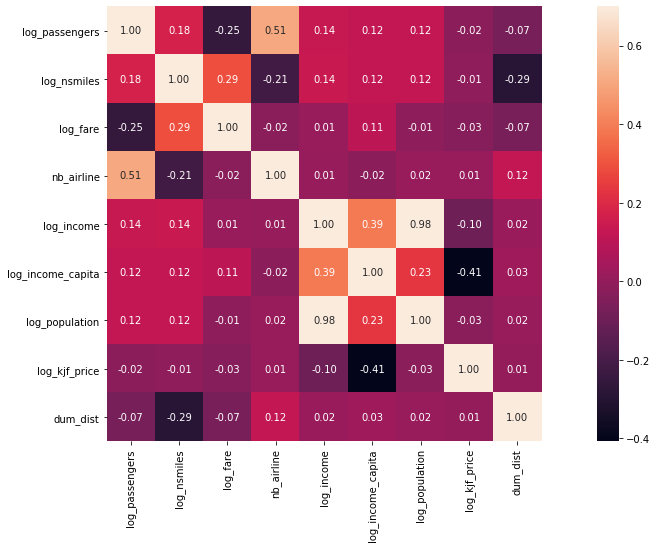

In [66]:
variables = ['log_passengers','log_nsmiles','log_fare','nb_airline','log_income',
             'log_income_capita','log_population','log_kjf_price','dum_dist']
corr = df[variables].corr()

plt.figure(figsize=(20,8))
sns.heatmap(corr, vmax=.7, square=True, annot=True, fmt = '.2f', )
plt.show()


## The linearity hypothesis

In [ ]:
df[variables].head()

We do not have a good visualization because of the size of the data. Therefore, we will keep randomly a few rows of the data and draw them.

In [152]:
import random
def df_split(x):
    np.random.shuffle(x)
    df_rand = pd.DataFrame(x[:np.int(1200),:], columns=col)
    return df_rand

col = ['log_passengers','log_nsmiles','log_fare','log_income','log_income_capita',
       'log_population','nb_airline','log_kjf_price','dum_dist']
df_rand = df_split(df[col].to_numpy())

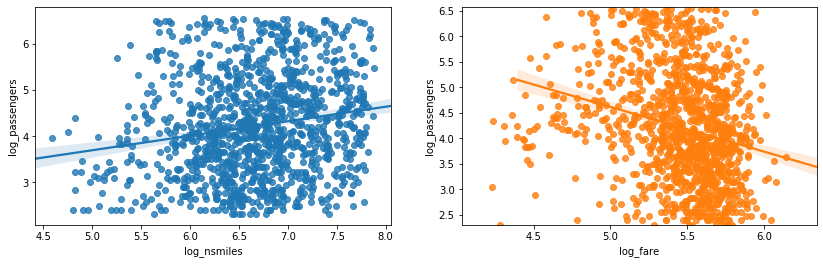

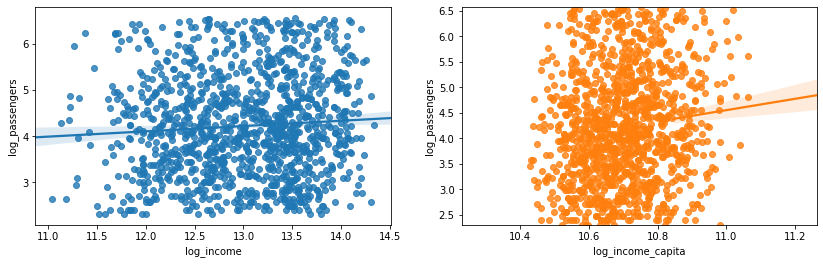

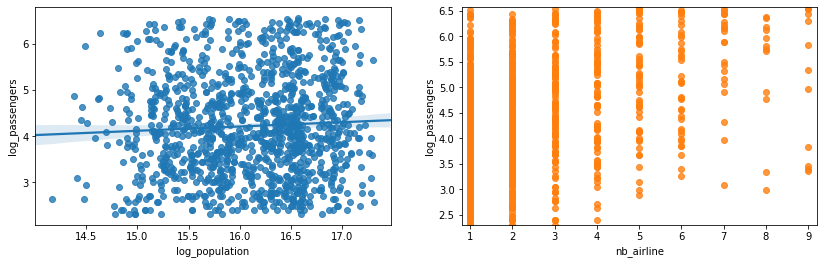

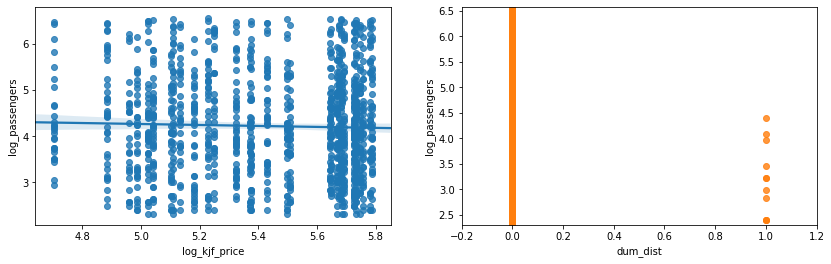

In [161]:
l = 0
for length in range(4):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    variables = col[1:]

    for i, j in zip((ax1, ax2), variables[l:l+2]):
        sns.regplot(data=df_rand, x=j, y='log_passengers', ax=i, fit_reg=True)
        plt.xlim(df_rand[j].min()-0.2, df_rand[j].max()+0.2)
        plt.ylim(df_rand.log_passengers.min(), df_rand.log_passengers.max())
        
    l+=2

In [171]:
regressors = ['log_nsmiles','log_fare','nb_airline','log_income_capita','log_population','log_kjf_price','dum_dist', 'dum_q2','dum_q3','dum_q4']


# use the list to select a subset from original DataFrame
X = df[regressors]
y = df['passengers']

# create a fitted model
lm = sm.OLS(y, X.astype(float)).fit()

# make predictions on the testing set
y_pred = lm.predict(X)

# print the summary
print (lm.summary())


                                 OLS Regression Results                                
Dep. Variable:             passengers   R-squared (uncentered):                   0.634
Model:                            OLS   Adj. R-squared (uncentered):              0.634
Method:                 Least Squares   F-statistic:                          1.744e+04
Date:                Mon, 23 Dec 2019   Prob (F-statistic):                        0.00
Time:                        15:14:23   Log-Likelihood:                     -6.2526e+05
No. Observations:              100844   AIC:                                  1.251e+06
Df Residuals:                  100834   BIC:                                  1.251e+06
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [172]:
regressors = ['log_nsmiles','log_fare','nb_airline','log_income_capita','log_population','log_kjf_price','dum_dist', 'dum_q2','dum_q3','dum_q4']

# use the list to select a subset from original DataFrame
X = df[regressors]
y = df['log_passengers']

thresh = 10

for i in np.arange(0,len(regressors)):
    vif = [variance_inflation_factor(X[regressors].values, ix) for ix in range(X[regressors].shape[1])]
    maxloc = vif.index(max(vif))
    if max(vif) > thresh:
        print ("vif :", vif)
        print ('\ndropping \'' + X[regressors].columns[maxloc] + '\' at index: ' + str(maxloc))
        del regressors[maxloc]
    else:
        break

print ('\nFinal variables:', regressors)

vif : [145.7140537726178, 346.0274149502731, 2.890342642146482, 1179.7398764609138, 697.869999371751, 262.6207333043964, 1.0883484223854751, 1.9261096327157765, 1.910848048185053, 1.9197659267954885]

dropping 'log_income_capita' at index: 3
vif : [144.17650703056, 271.63417547631997, 2.8868550397819974, 345.53368078204704, 231.1370158085182, 1.083345775310579, 1.9257043375921246, 1.9086119882793113, 1.9163851806257328]

dropping 'log_population' at index: 3
vif : [133.2338850082379, 222.2514426153667, 2.859361538932086, 166.0453673677754, 1.0750267202547141, 1.9252729781172175, 1.9076899235817129, 1.9150423202540774]

dropping 'log_fare' at index: 1
vif : [91.42765833912671, 2.8006069832088554, 98.98719314291456, 1.0663651878413374, 1.9240441750844999, 1.9068721076647752, 1.914612540347172]

dropping 'log_kjf_price' at index: 2

Final variables: ['log_nsmiles', 'nb_airline', 'dum_dist', 'dum_q2', 'dum_q3', 'dum_q4']


In [173]:
# use the list to select a subset from original DataFrame
X = df[regressors]
y = df['passengers']

# create a fitted model
lm = sm.OLS(y, X.astype(float)).fit()

# make predictions on the testing set
y_pred = lm.predict(X)

# print the summary
print (lm.summary())


                                 OLS Regression Results                                
Dep. Variable:             passengers   R-squared (uncentered):                   0.566
Model:                            OLS   Adj. R-squared (uncentered):              0.566
Method:                 Least Squares   F-statistic:                          2.190e+04
Date:                Mon, 23 Dec 2019   Prob (F-statistic):                        0.00
Time:                        15:15:18   Log-Likelihood:                     -6.3383e+05
No. Observations:              100844   AIC:                                  1.268e+06
Df Residuals:                  100838   BIC:                                  1.268e+06
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0

## A3. Normality of the Residuals

In [170]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

model = smf.ols("log_passengers ~ log_nsmiles+log_fare+nb_airline+log_income+log_population+log_jf_price+jf_change+dum_dist+dum_q1+dum_q2+dum_q3+dum_q4", data= df).fit()
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
lzip(name, test)

[('Jarque-Bera', 1659.9329093066412),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 0.200268479601649),
 ('Kurtosis', 2.8624509184936)]

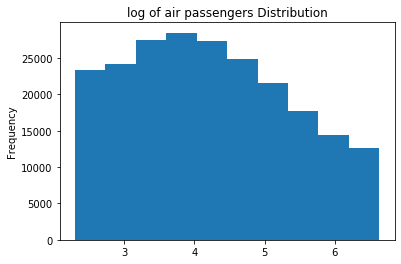

In [171]:
df['log_passengers'].plot(kind='hist', title= 'log of air passengers Distribution')

Text(0.5, 1.0, 'Model1 Residuals Q-Q Plot')

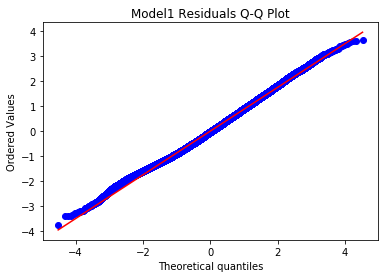

In [172]:
from scipy import stats

stats.probplot(model.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")
z
#Saving plot as a png
#plt.savefig("Model1_Resid_qqplot.png")


0.9967341534030871

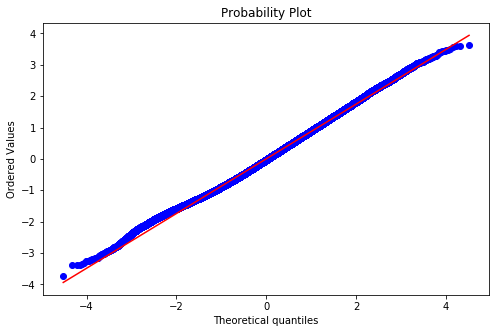

In [173]:
import scipy as sp

fig, ax = plt.subplots(figsize=(8,5))
_, (__, ___, r) = sp.stats.probplot(model.resid, plot=ax, fit=True)
r**2


## A4. Homoscedasticity

In [174]:
homoscedasticity = """
_, pval, __, f_pval = sms.stats.diagnostic.het_breuschpagan(lm.resid, X)
print('pval:',  pval, '\nf_pval:',f_pval)"""

name = ['Lagrange multiplier statistic', 'P-value','f-value','f P-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)
#lzip(name, test)
print(name[0],'=', round(test[0],2),';', name[1],'=', round(test[1],2),';',
      name[2],'=', round(test[2],2),';', name[3],'=', round(test[3],2))

Lagrange multiplier statistic = 1691.02 ; P-value = 0.0 ; f-value = 154.9 ; f P-value = 0.0


- The test is significant meaning the data violates the assumption of homoscedasticity, i.e. heteroscedasticit is present in the data.

Panel data test: https://bashtage.github.io/linearmodels/panel/results.html

https://bashtage.github.io/linearmodels/doc/panel/pandas.html  
Models for Panel Data: https://bashtage.github.io/linearmodels/doc/panel/models.html#linearmodels.panel.model.PanelOLS

https://github.com/statsmodels/statsmodels/issues/4792

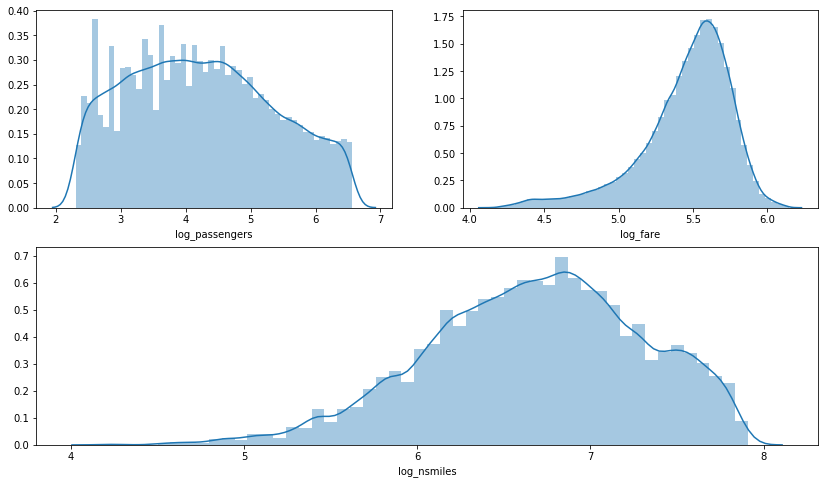

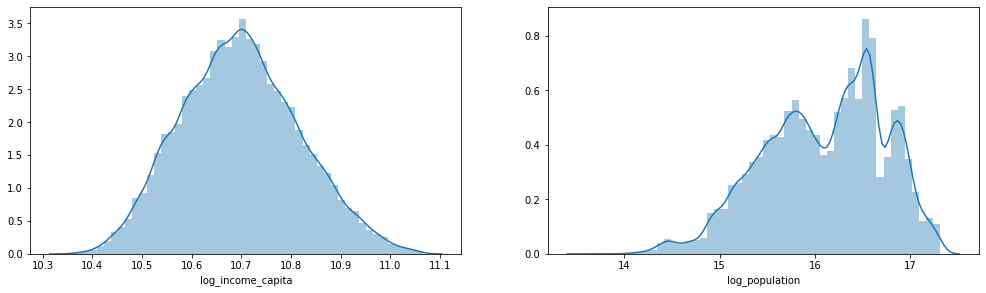

In [162]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
sns.distplot(df['log_passengers'])

plt.subplot(2,2,2)
sns.distplot(df['log_fare'])

plt.subplot(2,1,2)
sns.distplot(df['log_nsmiles'])
plt.show()

plt.figure(figsize=(17,10))
plt.subplot(2,2,1)
sns.distplot(df['log_income_capita'])

plt.subplot(2,2,2)
sns.distplot(df['log_population'])
plt.show()


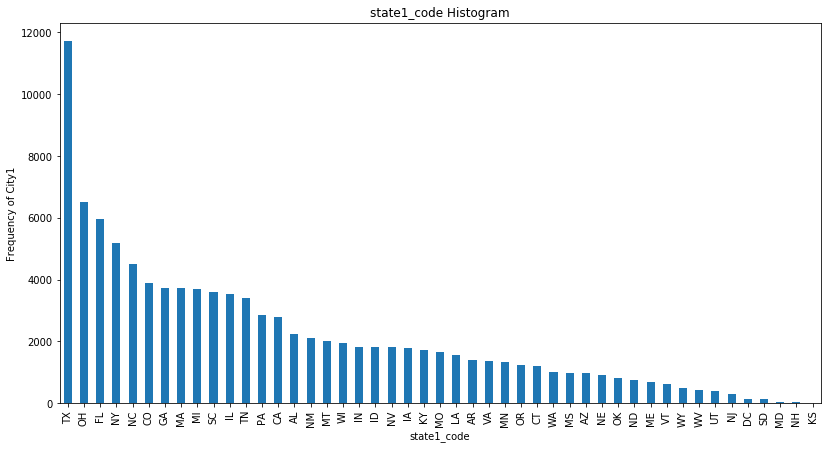

In [163]:
plt.figure(figsize=(30, 7))
plt.subplot(1,2,2)
plt1 = df['state1_code'].value_counts().plot('bar')
plt.title('state1_code Histogram')
plt1.set(xlabel = 'state1_code', ylabel='Frequency of City1')

plt.show()

In [43]:
import folium
from folium import plugins
from folium.plugins import HeatMap

# US Coordinates: 37.0902° N, 95.7129° W
map_hooray = folium.Map(location=[39, -97], zoom_start = 4.5)


In [44]:
heat_df = df[['latitude_city1', 'longitude_city1', 'latitude_city2', 'longitude_city2']]
heat_df = heat_df.dropna(axis=0, subset=['latitude_city1', 'longitude_city1', 'latitude_city2', 'longitude_city2'])

heat_df.drop_duplicates(keep='first', inplace = True) # Drop the duplicates values


In [45]:
heat_df = heat_df.astype({'latitude_city1':float, 'latitude_city2':float, 'longitude_city1':float, 'longitude_city2':float})

# List comprehension to make out list of lists
heat_data = [[row['latitude_city2'],row['longitude_city2']] for index, row in heat_df[['latitude_city2', 'longitude_city2']].drop_duplicates().iterrows()]
HeatMap(heat_data).add_to(map_hooray)
map_hooray